<a href="https://colab.research.google.com/github/htadashi/Coursera_Capstone/blob/master/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries



In [3]:
import urllib.request
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import r2_score

import folium
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data mining

#### Find restaurants in New York City using Foursquare API

Since the maximum limit of returned queries is 50, multiple searches will be done and merged, dropping the duplicate data.

In [0]:
# Fousquare API documentation available at https://developer.foursquare.com/docs/api-reference/venues/search/

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # Maximum limit is 50
RADIUS = 5000 # 5km
CATEGORY = '4bf58dd8d48988d1d2941735' # Sushi restaurants (List of categories: https://developer.foursquare.com/docs/build-with-foursquare/categories/)
LL_LIST = ['40.7859, -73.9742', \
           '40.7465, -73.9843', \
           '40.7788, -73.9066', \
           '40.7093, -73.9566', \
           '40.7380, -73.8801', \
           '40.6736, -73.8448', \
           '40.5988, -73.9448', \
           '40.6047, -74.0917', \
           '40.7684, -73.8327', \
           '40.7218, -74.0094'] # List of New York City coordinates to search

venues_list = []              

for ll in LL_LIST:
  # create the API request URL for venues of category 'CATEGORY'
  url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}&limit={}&intent=browse'.format(
  CLIENT_ID, 
  CLIENT_SECRET,
  VERSION,   
  ll,  
  RADIUS,
  CATEGORY, 
  LIMIT)

  # make the GET request
  results = requests.get(url).json()["response"]['venues']

  # append the relevant results to venues_list
  venues_list.append([(  
  v['name'], 
  v['id'],
  v['location']['lat'], 
  v['location']['lng'],  
  v['categories'][0]['name']) for v in results])

In [0]:
# generate dataframe and check some rows

restaurants = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
restaurants.columns = ['Name','id','Latitude','Longitude','Category']

restaurants = restaurants.drop_duplicates()
restaurants.head()

,Name,id,Latitude,Longitude,Category
0,KazuNori: The Original Hand Roll Bar,58b8ed467220e661ddf34104,40.745157,-73.988212,Japanese Restaurant
1,Citarella Gourmet Market - Upper West Side,4a624a38f964a520aac31fe3,40.781041,-73.981753,Grocery Store
2,Sushi Yasaka,4ea75442f7903beac0782454,40.779425,-73.983531,Sushi Restaurant
3,Sushi Ishikawa,593747b672475054e94bd3d4,40.768741,-73.954126,Sushi Restaurant
4,Yuka Japanese Restaurant,4423cae2f964a52099311fe3,40.774581,-73.954206,Sushi Restaurant


#### Extract restaurant features from Foursquare


In [0]:
prices_list           = []
ratings_list          = []
creation_epoch_list   = []
n_likes_list          = []
n_photos_list         = []
has_reservation_list  = []
has_credit_card_list  = []
has_outdoor_list      = []
has_delivery_list     = []

for id in restaurants['id']:

  has_reservation_info = False
  has_credit_card_info = False
  has_outdoor_info     = False
  has_delivery_info    = False
  
  # create the API request URL for venues details 
  # for more information, see: https://developer.foursquare.com/docs/api-reference/venues/details/ 
  venue_id = id
  url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
    venue_id,
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION)  
  
  req_result = requests.get(url).json()["response"]
  if "venue" in req_result:
    venue_result = req_result['venue']
    if "price" in venue_result:
      prices_list.append(venue_result['price']['tier'])
    else:
      prices_list.append(np.nan)
    if "rating" in venue_result:
      ratings_list.append(venue_result['rating'])
    else:
      ratings_list.append(np.nan)
    if "createdAt" in venue_result:
      creation_epoch_list.append(venue_result['createdAt'])
    else:
      creation_epoch_list.append(np.nan)
    if "likes" in venue_result:
      n_likes_list.append(venue_result['likes']['count'])
    else:
      n_likes_list.append(0)
    if "photos" in venue_result:
      n_photos_list.append(venue_result['photos']['count'])
    else:
      n_photos_list.append(0)
    if "attributes" in venue_result:
      attributes_list = venue_result['attributes']['groups']
      for i in range(len(attributes_list)):
        attribute = attributes_list[i]['items'][0]
        if(attribute['displayName'] == "Reservations"):
          has_reservation_info = True          
          has_reservation_list.append(attribute['displayValue'])
        if(attribute['displayName'] == "Credit Cards"):
          has_credit_card_info = True
          has_credit_card_list.append(attribute['displayValue'])
        if(attribute['displayName'] == "Outdoor Seating"):
          has_outdoor_info = True
          has_outdoor_list.append(attribute['displayValue'])
        if(attribute['displayName'] == "Delivery"):
          has_delivery_info = True
          has_delivery_list.append(attribute['displayValue'])
    else:
      # Assume that these services are not available
      has_reservation_list.append(0)
      has_credit_card_list.append(0)
      has_outdoor_list.append(0)
      has_delivery_list.append(0)
    # Assume that if there is no info then services are not available
    if(not has_reservation_info):
      has_reservation_list.append(0)
    if(not has_credit_card_info):
      has_credit_card_list.append(0)
    if(not has_outdoor_info):
      has_outdoor_list.append(0)
    if(not has_delivery_info):
      has_delivery_list.append(0)
  else:
    prices_list.append(np.nan)
    ratings_list.append(np.nan)
    creation_epoch_list.append(np.nan)
    n_likes_list.append(0) 
    n_photos_list.append(0)
    has_reservation_list.append(0)
    has_credit_card_list.append(0)
    has_outdoor_list.append(0)
    has_delivery_list.append(0)


In [0]:
# Merge price with features
restaurants['Price tier']       = prices_list
restaurants['Rating']           = ratings_list
restaurants['Creation epoch']   = creation_epoch_list
restaurants['Number of likes']  = n_likes_list
restaurants['Number of photos'] = n_photos_list
restaurants['Reservations']     = has_reservation_list
restaurants['Credit cards']     = has_credit_card_list
restaurants['Outdoor seating']  = has_outdoor_list
restaurants['Delivery option']  = has_delivery_list

restaurants.head()

,Name,id,Latitude,Longitude,Category,Price tier,Rating,Creation epoch,Number of likes,Number of photos,Reservations,Credit cards,Outdoor seating,Delivery option
0,KazuNori: The Original Hand Roll Bar,58b8ed467220e661ddf34104,40.745157,-73.988212,Japanese Restaurant,3.0,9.3,1488514374,519,209,No,Yes,No,No Delivery
1,Citarella Gourmet Market - Upper West Side,4a624a38f964a520aac31fe3,40.781041,-73.981753,Grocery Store,NaN,8.4,1247955512,98,65,0,0,0,Delivery
2,Sushi Yasaka,4ea75442f7903beac0782454,40.779425,-73.983531,Sushi Restaurant,2.0,9.0,1319588930,652,494,0,Yes (incl. Discover & Visa),No,0
3,Sushi Ishikawa,593747b672475054e94bd3d4,40.768741,-73.954126,Sushi Restaurant,2.0,8.7,1496795062,41,69,0,0,0,0
4,Yuka Japanese Restaurant,4423cae2f964a52099311fe3,40.774581,-73.954206,Sushi Restaurant,2.0,7.9,1143196386,134,269,No,Yes (incl. Discover & Visa),No,Delivery


#### Data preprocessing

In [0]:
restaurants.shape

(282, 14)

In [0]:
# Preprocess NaN in the data
# drop NaN in the data 
restaurants = restaurants.dropna()
restaurants.shape

(182, 14)

In [0]:
# Replace string for integer values in dataframe 
# (Assume that if information is not available, the respective service is not available)
mapping = {'No': 0, 'Yes': 1, \
           'No Delivery':0, 'Delivery':1,\
           'Yes (incl. American Express)':1, \
           'Yes (incl. MasterCard & American Express)':1, \
           'Yes (incl. Discover & Visa)':1, \
           'Yes (incl. American Express & MasterCard)':1, \
           'Yes (incl. Visa & MasterCard)':1, \
           'Yes (incl. Visa & American Express)':1, \
           'Yes (incl. Discover)':1, \
           'Yes (incl. Discover & MasterCard)': 1}
restaurants = restaurants.replace({'Reservations': mapping, 'Credit cards': mapping, 'Outdoor seating': mapping, 'Delivery option': mapping})
restaurants.head()

,Name,id,Latitude,Longitude,Category,Price tier,Rating,Creation epoch,Number of likes,Number of photos,Reservations,Credit cards,Outdoor seating,Delivery option
0,KazuNori: The Original Hand Roll Bar,58b8ed467220e661ddf34104,40.745157,-73.988212,Japanese Restaurant,3.0,9.3,1488514374,519,209,0,1,0,0
2,Sushi Yasaka,4ea75442f7903beac0782454,40.779425,-73.983531,Sushi Restaurant,2.0,9.0,1319588930,652,494,0,1,0,0
3,Sushi Ishikawa,593747b672475054e94bd3d4,40.768741,-73.954126,Sushi Restaurant,2.0,8.7,1496795062,41,69,0,0,0,0
4,Yuka Japanese Restaurant,4423cae2f964a52099311fe3,40.774581,-73.954206,Sushi Restaurant,2.0,7.9,1143196386,134,269,0,1,0,1
5,Nobu Fifty Seven,45228b3cf964a520d93a1fe3,40.763896,-73.976062,Sushi Restaurant,3.0,9.1,1159891772,779,783,0,1,0,0


# Feature selection and data analysis

#### Variables correlation

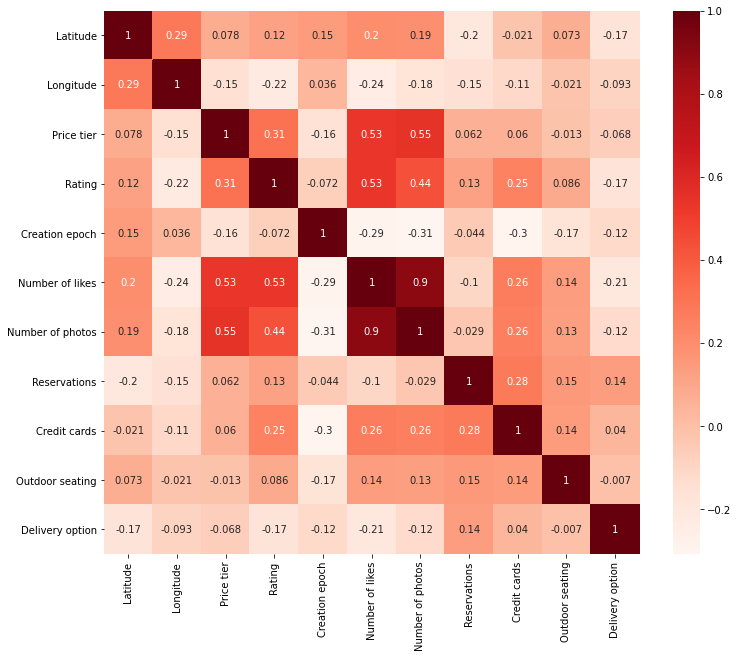

In [6]:
# Pearson Correlation
plt.figure(figsize=(12,10))
cor = restaurants.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Map labeled by rating

In [7]:
# create map
city = 'New York, NY'

geolocator = Nominatim(user_agent="coursera_explorer")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Toner')

for lat, lon, rate in zip(restaurants['Latitude'], restaurants['Longitude'], restaurants['Rating']):
  if rate >= 9.0:
    color = 'blue'
  if rate <= 9.0 and rate >= 8.0:
    color = 'green'
  if rate <= 8.0 and rate >= 7.0:
    color = 'yellow'
  if rate <= 7.0 and rate >= 6.0:
    color = 'orange'
  if rate <= 6.0:
    color = 'red'
  
  icon = folium.DivIcon(html=f"""<font size="6"><div style="color: {color};"><b>{str(rate)}</b></div></font>""")
  folium.Marker([lat, lon], icon=icon).add_to(map_clusters)
  

map_clusters

#### Box and scatter plots

##### Price tier 

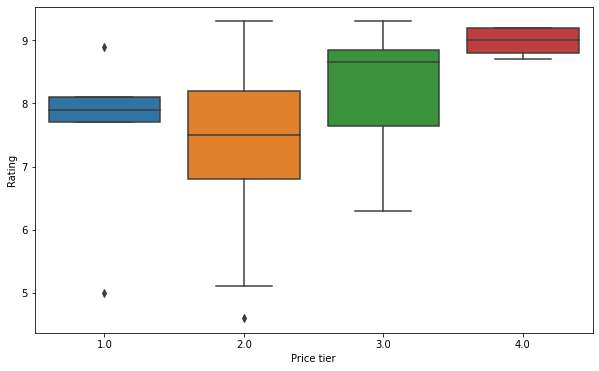

In [8]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Price tier', y='Rating', data=restaurants)

##### Number of likes and number of photos

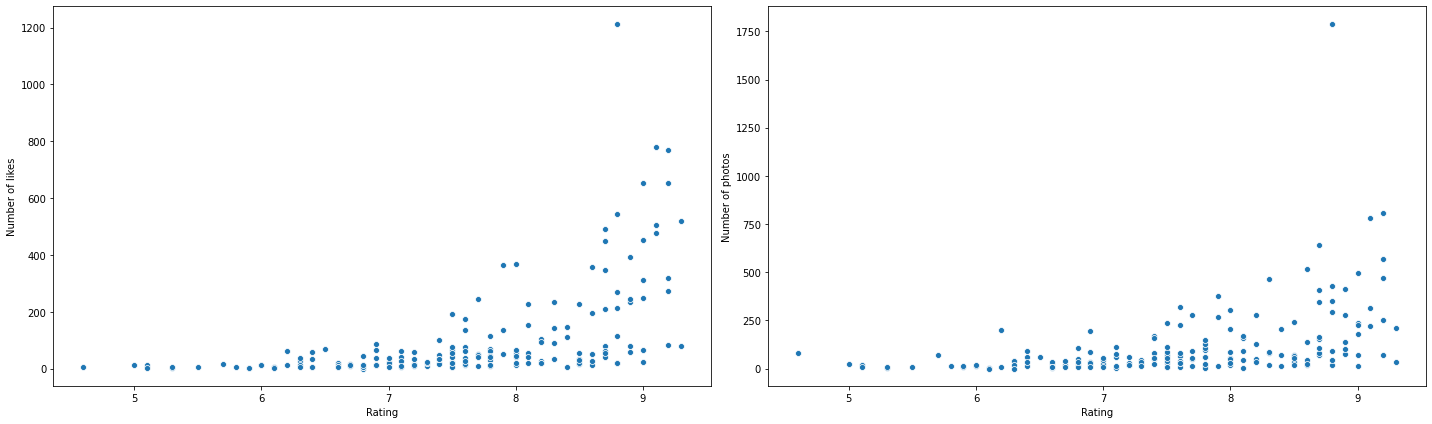

In [9]:
plt.figure(figsize = (20, 6))
ax1 = plt.subplot(1,2,1)
ax1 = sns.scatterplot(x='Rating', y='Number of likes', data=restaurants)
ax2 = plt.subplot(1,2,2)
ax2 = sns.scatterplot(x='Rating', y='Number of photos', data=restaurants)
plt.tight_layout()

In [10]:
# Get indexes for which column 'Number of likes' has value less than 100 and drop them
drop_indexes = restaurants[restaurants['Number of likes'] <= 100 ].index
restaurants_filtered = restaurants.drop(drop_indexes)

# Get indexes for which column 'Number of photos' has value less than 100 and drop them
drop_indexes = restaurants_filtered[restaurants_filtered['Number of photos'] <= 100 ].index
restaurants_filtered.drop(drop_indexes , inplace=True)

# Count the size of new dataset
restaurants_filtered.shape

(39, 14)

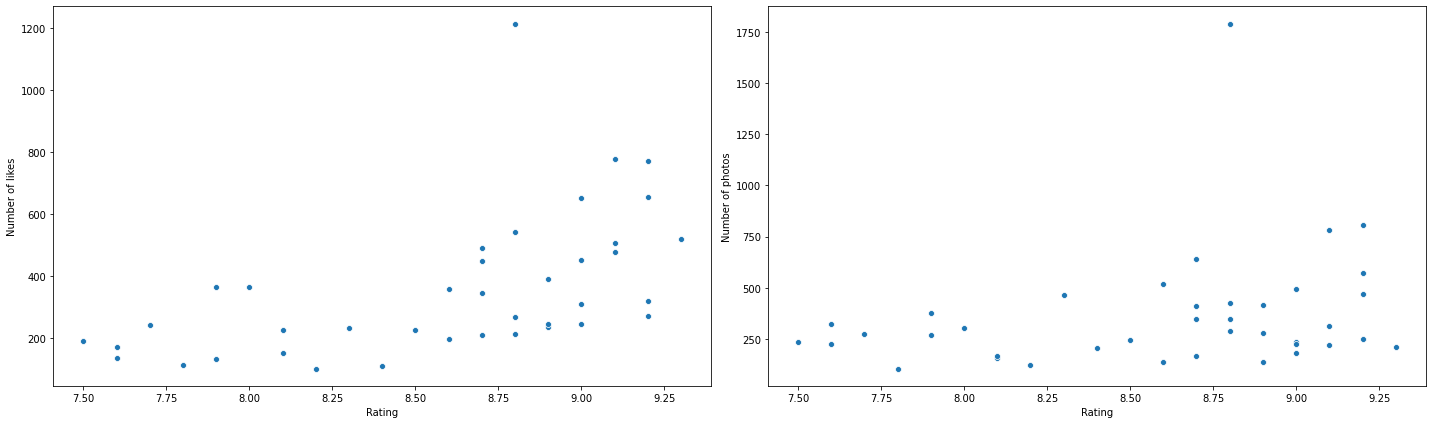

In [11]:
# Plot scatterplot after filtering
plt.figure(figsize = (20, 6))
ax1 = plt.subplot(1,2,1)
ax1 = sns.scatterplot(x='Rating', y='Number of likes', data=restaurants_filtered)
ax2 = plt.subplot(1,2,2)
ax2 = sns.scatterplot(x='Rating', y='Number of photos', data=restaurants_filtered)
plt.tight_layout()

##### Services and other features

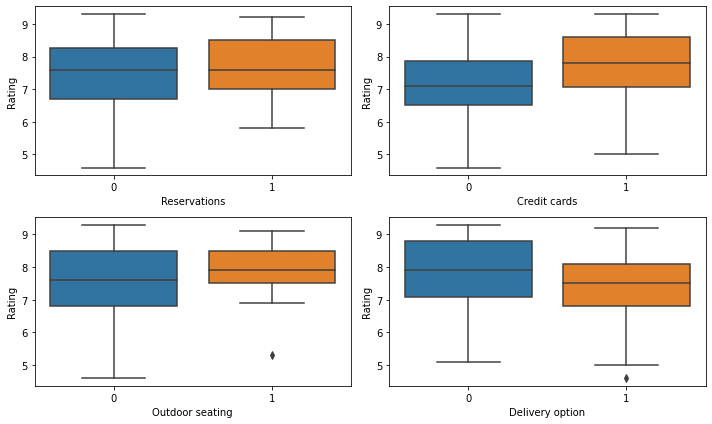

In [12]:
plt.figure(figsize = (10, 6))
ax1 = plt.subplot(2,2,1)
ax1 = sns.boxplot(x='Reservations', y='Rating', data=restaurants)
ax2 = plt.subplot(2,2,2)
ax2 = sns.boxplot(x='Credit cards', y='Rating', data=restaurants)
ax3 = plt.subplot(2,2,3)
ax3 = sns.boxplot(x='Outdoor seating', y='Rating', data=restaurants)
ax4 = plt.subplot(2,2,4)
ax4 = sns.boxplot(x='Delivery option', y='Rating', data=restaurants)
plt.tight_layout()

# Data modelling

#### Using ridge regression for rating prediction




In [13]:
# Feature selection
X = restaurants_filtered[['Number of likes','Number of photos']]
y = restaurants_filtered[['Rating']]

# Split dataset in training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Fit and test score
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 100))
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print("The R2 score is {}".format(r2_score(y_test, y_pred)))

The R2 score is 0.783505858515543


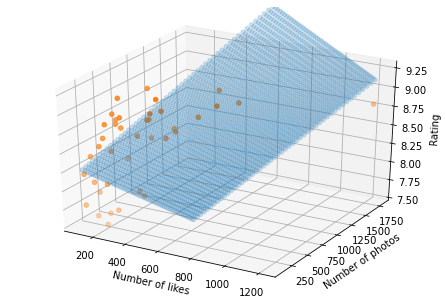

In [14]:
# Displaying the 3D graph
x = restaurants_filtered[['Number of likes']].to_numpy()
y = restaurants_filtered[['Number of photos']].to_numpy()
z = restaurants_filtered['Rating'].to_numpy()

# Create coordinate grid and predict using chosen regressor (https://stackoverflow.com/a/12891609/1163098)
X, Y = np.mgrid[min(x):max(x):50j, min(y):max(y):50j]
positions = np.vstack([X.ravel(), Y.ravel()])
zp = reg.predict(positions.T) 

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.scatter(X, Y, zp, alpha = 0.2)
ax.scatter(x, y, z)
ax.set_xlabel('Number of likes')
ax.set_ylabel('Number of photos')
ax.set_zlabel('Rating')
ax.set_zlim3d(np.min(z), np.max(z))

plt.show()